# 動的計画法

## 動的計画法である方策の評価関数を求める

ベルマン方程式は以下の式で表現できる。

$$
u_\pi (s) = \sum_{a, s'} \pi(a|s) p(s'|s, a) \{r(s, a, s') + \gamma u_\pi (s')\}
$$

この式は「現在の状態$s$の価値関数$u_\pi(s)$」と「次の状態$s'$の評価関数$u_\pi(s')$」の関係を表している。

これを評価関数の推定値$V_k$の更新式と捉えると以下の式で表現できる。なお、$k$は$k$回目の更新であることを表す。

$$
V_{k+1}(s) = \sum_{a, s'} \pi(a|s) p(s'|s, a) \{r(s, a, s') + \gamma V_k(s')\}\\
V_{k+1}(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V_k(s')\} \tag{1}
$$

これを繰り返すことで$V_k$が$u_\pi (s)$に収束することが証明されている。

## 簡単なワールドで方策評価を行う
### 問題設定
以下のようにL1とL2が隣り合ったグリッドを考える。状態L1から右(状態L2)に移動すると報酬は+1、状態L2から左(状態L1)に移動すると報酬は0である。

また、状態L1から左または状態L2から右に移動すると報酬は-1で状態は変化しない。

| L1 | L2 |

### 方策
左・右それぞれ$0.5$の確率でランダムに選択する方策を考える。

この問題では選択した行動に対して次の状態が一意に決まる決定論的な問題であるため、$s' = f(s, a)$より以下の式で表現できる。

$$
V_{k + 1} (s) = \sum_a \pi (a|s) \{r(s, a, s') + \gamma V_k (s')\} \tag{2}
$$

まず、$V_0(L1) = 0, V_0(L2) = 0$で初期化する。

In [ ]:
# 方策評価を行うプログラム
V = {"L1": 0, "L2": 0}
gamma = 0.9

for k in range(1, 101):
    # 式(2)に基づいて方策評価を計算
    V["L1"] = 0.5 * (-1 + gamma * V["L1"]) + 0.5 * (1 + gamma * V["L2"])
    V["L2"] = 0.5 * (0 + gamma * V["L1"]) + 0.5 * (-1 + gamma * V["L2"])
    print(V)

{'L1': 0.0, 'L2': -0.5}
{'L1': -0.22499999999999998, 'L2': -0.8262499999999999}
{'L1': -0.47306249999999994, 'L2': -1.084690625}
{'L1': -0.70098890625, 'L2': -1.3035557890625}
{'L1': -0.902045112890625, 'L2': -1.4925204058789063}
{'L1': -1.0775544834462891, 'L2': -1.656533700196338}
{'L1': -1.2303396826391824, 'L2': -1.7990930222759842}
{'L1': -1.363244717211825, 'L2': -1.9230519827695143}
{'L1': -1.4788335149916028, 'L2': -2.030848473992503}
{'L1': -1.5793568950428476, 'L2': -2.1245924160659078}
{'L1': -1.6667771899989399, 'L2': -2.2061163227291813}
{'L1': -1.7428020807276545, 'L2': -2.2770132815555764}
{'L1': -1.808916913027454, 'L2': -2.338668587562364}
{'L1': -1.8664134752654182, 'L2': -2.392286928272502}
{'L1': -1.916415181592064, 'L2': -2.4389159494390547}
{'L1': -1.9598990089640036, 'L2': -2.4794667312813763}
{'L1': -1.997714583110421, 'L2': -2.514731591476309}
{'L1': -2.0306007785640285, 'L2': -2.545399566518152}
{'L1': -2.059200155286981, 'L2': -2.57206987481231}
{'L1': -2.084

## 結果の確認
問題設定より、ランダムに行動を選択する方策の真の評価関数の値は以下のようになる。

$$
u(L1) = -2.25, u(L2) = -2.75
$$

このことから、上記のプログラムを用いることで高い精度で評価関数の値を得られることがわかる。

また、上記プログラムでは更新回数を100回としていたが、更新前と更新後の値の絶対値が一定以下になると終了とすることができる。

## より大きな問題への適用

$3 \times 4$のグリッドマスについて考える。左上を$(0, 0)$とし、ルールは以下の通りである。

- グリッド内を上下左右に移動できる
- $(1, 1)$に壁があり、ここに移動することはできない
- 壁に当たった場合の報酬は$0$で状態は変化しない
- $(0, 3)$に移動すると報酬$+1$を得る
- $(1, 3)$に移動すると報酬$-1$を得る
- $(2, 0)$を初期位置、$(0, 3)$をゴールとする

この問題は終わりのあるエピソードタスクである。

### プログラムの設計
`GridWorld`クラスを実装する。

In [10]:
import numpy as np
from utils import Renderer

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 上、下、左、右
        self.action_map = {
            0: (-1, 0),  # 上
            1: (1, 0),   # 下
            2: (0, -1),  # 左
            3: (0, 1),   # 右
        }
        self.reward_map = np.array([
            [0, 0, 0, 1],
            [0, None, 0, -1],
            [0, 0, 0, 0],
        ])
        self.goal_state = (0, 3)  # ゴール地点
        self.wall_state = (1, 1)  # 壁の地点

    @property
    def height(self):
        return self.reward_map.shape[0]
    
    @property
    def width(self):
        return self.reward_map.shape[1]
    
    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space
    
    # 状態を取得
    def states(self):
        for i in range(self.height):
            for j in range(self.width):
                yield (i, j)
                
    def next_state(self, state, action):
        move = self.action_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        nx, ny = next_state
        
        # ワールドの端なら状態は変わらない
        if nx < 0 or nx >= self.height or ny < 0 or ny >= self.width:
            return state
        # 壁なら状態は変わらない
        elif self.reward_map[nx, ny] is None:
            return state
        
        return next_state
    
    def reward(self, state):
        return self.reward_map[state]
    
    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state, self.wall_state)
        renderer.render_v(v, policy, print_value)

In [ ]:
from collections import defaultdict


def eval_step(pi: defaultdict[tuple[int, int], dict[int, float]], V: defaultdict, env: GridWorld, gamma: float):
    """
    方策評価の1ステップを実行する関数
    pi: 方策 pi[state] -> stateからの移動方向
    V: 現在の状態価値関数
    env: 環境
    gamma: 割引率
    """
    # 各地点について
    for state in env.states():
        # ゴール地点の評価関数は0
        if state == env.goal_state:
            V[state] = 0
            continue
        
        action_probs = pi[state] # 現地点の行動確率
        new_V = 0
        
        # ある地点からの各行動について
        for action, action_prob in action_probs.items():
            # 次の状態を取得
            next_state = env.next_state(state, action)
            # 報酬を取得
            reward = env.reward(next_state)
            # 次の状態の価値関数を取得
            new_V += action_prob * (reward + gamma * V[next_state])
        V[state] = new_V
    return V

defaultdict(<function <lambda> at 0x0000020C0FE52FC0>, {(0, 0): 0.0256663947864485, (1, 0): -0.03181367353370739, (0, 1): 0.09455374934534977, (0, 2): 0.20546499234745147, (1, 2): -0.49795210910078397, (0, 3): 0, (2, 0): -0.10343315257870167, (2, 1): -0.221022921886541, (1, 1): -0.14765286489289256, (2, 2): -0.4368451010901099, (1, 3): -0.3726771560319816, (2, 3): -0.7857136506161768})


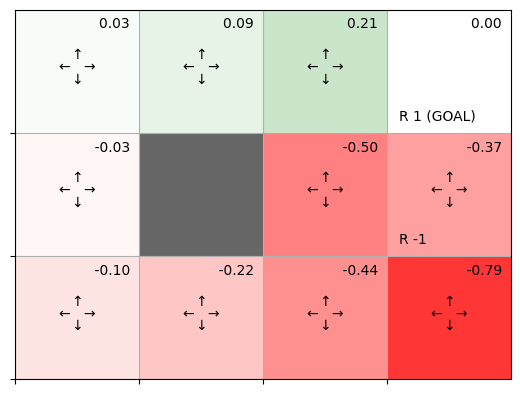

In [23]:
env = GridWorld()
gamma = 0.9

# ランダムに移動する方策
pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
V = defaultdict(lambda: 0)

def policy_eval(pi: defaultdict[tuple[int, int], dict[int, float]], V: defaultdict, env: GridWorld, gamma: float, threshold: float = 1e-10):
    """
    方策評価を行う関数
    pi: 方策 pi[state] -> stateからの移動方向
    V: 現在の状態価値関数
    env: 環境
    gamma: 割引率
    threshhold: 収束判定の閾値
    """
    while True:
        # 方策評価の1ステップを実行
        V_prev = V.copy()
        V = eval_step(pi, V, env, gamma)
        # 収束判定
        if max([abs(V[state] - V_prev[state]) for state in V.keys()]) < threshold:
            break
    return V

print(policy_eval(pi, V, env, gamma))
env.render_v(V, pi, print_value=True)

## 結果の確認
報酬がマイナスのマスに近いほど、評価関数の値が小さくなっていることがわかる。

このことから、正しく評価関数の値を得られたと考えられる。